In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import save_model, load_model
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# get the data from kaggle compitition
filename = 'fer2013.csv'
# 7 labels in our data in the form of 0,1,2,3,4,5,6,7
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

/home/hfahad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def getData(filename):
    # image sizes are 48x48
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

X, Y = getData(filename)
num_class = len(set(Y))

# To see number of training data point available for each label
def count_by_class(Y):
    count={}
    for i in range(len(set(Y))):
        temp=Y
        b=np.logical_and(temp==i,temp==i)
        count[i]=len(temp[b])
    return count

balance = count_by_class(Y)

N, D = X.shape
X = X.reshape(N, 48, 48, 1)


# Split in  training set : validation set : 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)




In [3]:
batch_size = 128
epochs = 50

#datagen for Data Augmentation
datagen=ImageDataGenerator(horizontal_flip=True,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2)

# CNN model with six Convolution layer & two fully connected layer
def CNN_Model():
    # Initialising the CNN
    model = Sequential()

    # Set 1
    ## 1 Convolution layer
    model.add(Conv2D(64,(3,3), border_mode='same', input_shape=(48, 48,1)))
    model.add(Activation('relu'))
    
    ## 2nd Convolution layer
    model.add(Conv2D(64,(5,5), border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Set 2
    ## 3rd Convolution layer
    model.add(Conv2D(128,(3,3), border_mode='same'))
    model.add(Activation('relu'))
   
    ## 4th Convolution layer
    model.add(Conv2D(128,(5,5), border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Set 3
    ## 5th Convolution layer
    model.add(Conv2D(256,(3,3), border_mode='same'))
    model.add(Activation('relu'))
    
    ## 6th Convolution layer
    model.add(Conv2D(256,(5,5), border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flattening
    model.add(Flatten())

    # 1st Fully connected layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # 2nd Fully connected layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_class, activation='softmax'))
    
    adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model




In [4]:
def CNN_Model_Saved():
    #load weights from h5 file
    model=load_model("Deep_cnn_model.h5")
    return model
# if you use a save model then turn it True ,otherwise if you run the whole code turn it False
is_model_saved = True


# If model is not saved train model then use this function
if(is_model_saved==False ):
    # Train model
    model = CNN_Model()
    # Note : Augmenting Data Generator
    datagen.fit(X_train,seed=0)
    steps_per_epoch=len(X_train)/batch_size
    model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size,seed=0),
                       steps_per_epoch=steps_per_epoch ,
                       epochs=epochs ,
                       verbose=1)
    #save our model
    model.save("Deep_cnn_model.h5eep")
    print("Saved model to disk")

# if you use the save train model
else:
    # Load the trained model
    print("Load model from disk")
    model = CNN_Model_Saved()


# Model will predict the probability values for 7 labels for a test image
score = model.predict(X_test)
print (model.summary())
results = model.evaluate(X_test, y_test, verbose=1) 
print('loss data:', results[0]) 
print('Accuracy on a test data:', results[1]) 



Load model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        

Normalized confusion matrix
[[0.61 0.   0.07 0.05 0.14 0.01 0.12]
 [0.45 0.36 0.07 0.04 0.04 0.   0.05]
 [0.16 0.   0.52 0.02 0.14 0.07 0.1 ]
 [0.03 0.   0.02 0.88 0.01 0.01 0.05]
 [0.11 0.   0.17 0.03 0.5  0.01 0.19]
 [0.03 0.   0.17 0.08 0.01 0.69 0.02]
 [0.04 0.   0.07 0.09 0.09 0.04 0.67]]


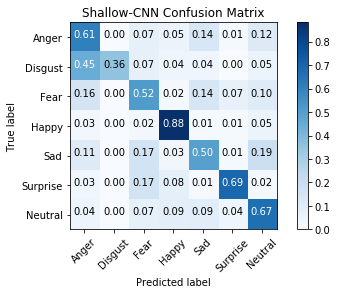

In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
new_X = [ np.argmax(item) for item in score ]
y_test2 = [ np.argmax(item) for item in y_test]
# Compute confusion matrix
cnf_matrix =confusion_matrix(y_test2,new_X, labels=None, sample_weight=None)
np.set_printoptions(precision=2)
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Shallow-CNN Confusion Matrix')

plt.show()

In [7]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test2,new_X)

(array([0.56, 0.91, 0.48, 0.85, 0.59, 0.8 , 0.59]),
 array([0.61, 0.36, 0.52, 0.88, 0.5 , 0.69, 0.67]),
 array([0.58, 0.51, 0.5 , 0.87, 0.54, 0.74, 0.62]),
 array([484,  56, 502, 920, 599, 442, 586]))

['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
[[7.00e-02 4.41e-05 2.40e-03 8.45e-01 9.26e-03 2.37e-03 7.13e-02]]
Prediction: Happy


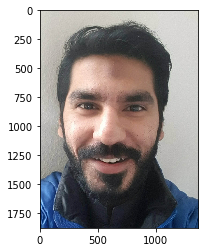

In [8]:
# prediction of our images

import numpy as np
from keras.models import save_model, load_model
from keras.preprocessing import image

name_img='fahad_happy.jpg'
# convert image into 48 x 48 size
test_image=image.load_img(name_img, target_size =(48,48))
test_image=image.img_to_array(test_image)
test_image.shape

# Because our images are color or in RGB thats why concert it into gray scale 
def rgb2gray(rgb): 
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

test_image=rgb2gray(test_image)
test_image.shape

def new_img_convert(img):
    img=img.reshape((48,48,1))
    img/=255
    img=np.expand_dims(img, axis=0)
    return img

img=new_img_convert(test_image)
img.shape
# Load the model to predict my image 
model =load_model('Deep_cnn_model.h5')
result=model.predict(img)
print (label_map)
print(result)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('fahad_happy.jpg'))

new_X = np.argmax(result)
print('Prediction:',label_map[new_X])